#### Goal Definition

This assignment aims to build an image classifier using a convolutional neural network (CNN). The images, accessible at https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia, represent chest X-ray images
of patients. Two possible types of labels are considered: normal and pneumonia. Put another way, each sample represents either a normal patient or
a patient suffering from pneumonia. You are required to build your model
following the LeNet 5 architecture presented in class.

In [1]:
import Base
using Dates
using Random: shuffle!
using Statistics: mean

using Images
using PyPlot

using Flux
using Flux: onehotbatch, onecold
using Flux.Losses: logitbinarycrossentropy

#### Data Preparation

In [2]:
const TRAINIMAGES = "./data/train"
const TESTIMAGES = "./data/test"
const LABELS = ("normal", "pneumonia")
const NLABELS = length(LABELS)
const IMAGE_SIZE = (128, 128) # rows x columns
const lr = 0.001 # learning rate
const batchsize = 128;

In [3]:
function DataLoader(dir; batchsize=1, shuffle=false)
    data = get_data(dir, batchsize, shuffle)
    if batchsize <= 1 || batchsize >= length(data) * batchsize
        return ((transform(load(d[1])), onehotbatch([d[2]], 1:2)) for d in data)
    end
    (nrows, ncols) = IMAGE_SIZE
    return [load_batch(batch, (nrows, ncols, 1, bs)) for (batch, bs) in data]
end

function load_batch(img_batch, dims)
    labels_arr = [img[2] for img in img_batch]
    imgs_arr = Array{Float32}(undef, dims)
    for (i, img) in zip(1:length(img_batch), img_batch)
       imgs_arr[:, :, :, i] = transform(load(img[1]))[:, :, 1]
    end
    return imgs_arr, onehotbatch(labels_arr, 1:2)
end

function transform(img, image_size=IMAGE_SIZE)
    img = Gray.(imresize(img, image_size)) # resize & covert to gray-img
    img = Float32.(img) # convet to float32
    return reshape(img, image_size[1], image_size[2], 1, :)
end

function get_data(dir, batchsize=0, shuffle=false)
    # return data based on batchsize
    fnames = get_filenames(dir, shuffle=shuffle)
    len = length(fnames)
    
    if batchsize <= 1 || batchsize >= len
        return fnames
    end
    
    sample_size = trunc(Int64, len / batchsize)
    sample_sizes = [(n==1 ? n : (batchsize*(n-1))+1, batchsize*n) for n in 1:sample_size]
    indices = vcat(sample_sizes, [(sample_sizes[sample_size][2]+1, len)])
    batch_sizes = [ (u-l)+1 for (l, u) in indices]
    return [(fnames[ids[1]:ids[2]], bs) for (ids, bs) in zip(indices, batch_sizes)]
end

function get_filenames(dir; shuffle=false)
    fnames = [(fname, label=="normal"  ? 1 : 2) for label in LABELS
            for fname in readdir("$dir/$label", join=true)]
    return shuffle ? shuffle!(fnames) : fnames
end;

In [4]:
train_loader = DataLoader(TRAINIMAGES, batchsize=batchsize, shuffle=true)
test_loader  = DataLoader(TESTIMAGES, batchsize=batchsize);

#### Model

In [5]:
denselayer_in = prod((IMAGE_SIZE[1]÷4 - 3, IMAGE_SIZE[2]÷4 - 3, 16))
model = Chain(
    Conv((5, 5), 1=>6, relu, stride=2),
    Conv((5, 5), 6=>16, relu, stride=2),
    flatten,
    Dense(denselayer_in, 120, relu),
    Dense(120, 84, relu),
    Dense(84, NLABELS)
)

# model = Chain(
#     Conv((5, 5), 1=>6, relu),
#     MaxPool((2, 2)),
#     Conv((5, 5), 6=>16, relu),
#     MaxPool((2, 2)),
#     flatten,
#     Dense(denselayer_in, 120, relu), 
#     Dense(120, 84, relu), 
#     Dense(84, NLABELS)
# )

Chain(Conv((5, 5), 1=>6, relu), Conv((5, 5), 6=>16, relu), flatten, Dense(13456, 120, relu), Dense(120, 84, relu), Dense(84, 2))

In [6]:
const optimizer = ADAM(lr)
const criterion(output, target) = logitbinarycrossentropy(output, target);

#### Training

In [7]:
function training_loop(model, train_loader, test_loader; epochs=15)
    params = Flux.params(model)
    
    train_losses = []
    test_losses = []
    
    for epoch in 1:epochs
        train_loss = []
        t0 = Dates.now()
        for (input, target) in train_loader
            loss = 0
            grads = Flux.gradient(params) do
                output = model(input)
                loss = criterion(output, target) # got problem here
            end
            Flux.Optimise.update!(optimizer, params, grads)
            push!(train_loss, loss)
        end
        train_loss = mean(train_loss)
        push!(train_losses, train_loss)
        
        test_loss = []
        for (input, target) in test_loader
            output = model(input)
            loss = criterion(output, target)
            push!(test_loss, loss)
        end
        test_loss = mean(test_loss)
        push!(test_losses, test_loss)
        
        dt = Dates.now() - t0
        println("$epoch/$epochs: train-loss=$train_loss, test-loss=$test_loss, time=$dt")
    end
    return train_losses, test_losses
end;

In [8]:
train_loss, test_loss = training_loop(model, train_loader, test_loader);

1/15: train-loss=0.4407618, test-loss=0.3597546, time=44615 milliseconds
2/15: train-loss=0.18172888, test-loss=0.7506854, time=16516 milliseconds
3/15: train-loss=0.12563421, test-loss=0.70580924, time=16679 milliseconds
4/15: train-loss=0.1027501, test-loss=0.7674063, time=16874 milliseconds
5/15: train-loss=0.08789149, test-loss=0.78113616, time=17184 milliseconds
6/15: train-loss=0.077683896, test-loss=0.8349508, time=16875 milliseconds
7/15: train-loss=0.067586295, test-loss=0.8133764, time=17343 milliseconds
8/15: train-loss=0.058500867, test-loss=0.92977095, time=16334 milliseconds
9/15: train-loss=0.05095239, test-loss=1.0845883, time=16276 milliseconds
10/15: train-loss=0.04342768, test-loss=1.280125, time=17995 milliseconds
11/15: train-loss=0.049744826, test-loss=1.0191205, time=17647 milliseconds
12/15: train-loss=0.035408746, test-loss=1.2008064, time=16354 milliseconds
13/15: train-loss=0.036498398, test-loss=1.1275085, time=16764 milliseconds
14/15: train-loss=0.03699736

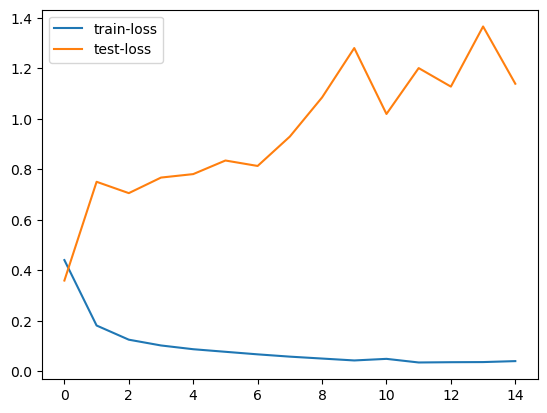

In [9]:
plot(train_loss, label="train-loss")
plot(test_loss, label="test-loss")
legend();

#### Model Evaluation
Evaluation of the model, with the confusion matrix, the accuracy, precision and recall.

In [10]:
function accuracy(loader, model)
    l = 0
    acc = 0
    total = 0
    for (input, target) in loader
        output = model(input)
        acc += sum(onecold(output) .== onecold(target))
        total += size(input)[end]
    end
    return acc=round(acc/total*100, digits=4)
end


y_trues = [l for (_, labels) in test_loader
           for l in onecold(labels)]
preds =  []
for (input, target) in test_loader
    output = model(input)
    preds = vcat(preds, onecold(output))
end

len = length(y_trues)
pneumonia_tp = 0
pneumonia_fp = 0

normal_tp = 0
normal_fp = 0

for (p, t) in zip(preds, y_trues)
 
    if p == t # model predicted yes
        if t == 1
            normal_tp += 1
        elseif t == 2
            pneumonia_tp += 1
        end
    end

    if p != t # model predicted no
        if t == 1
            normal_fp += 1
        elseif t == 2
            pneumonia_fp += 1
        end
    end
end

TP = pneumonia_tp
FP = normal_fp
FN = pneumonia_fp;

Accuracy

In [11]:
train_acc = accuracy(train_loader, model)
test_acc = accuracy(test_loader, model)
println("Train Accuracy=$train_acc, Test Accuracy=$test_acc")

Train Accuracy=98.7922, Test Accuracy=76.6026


Precision

In [12]:
precision = (TP / (TP + FP)) * 100
println("= $precision")

= 73.10606060606061


Recall

In [13]:
recall = (TP / (TP + FN)) * 100
println("= $recall")

= 98.97435897435898


Confusion Matrix

In [14]:
println("                      Confusion Matrix")
println()

cm = """
$len         | Predicted-Pneumonia | Predicted-Normal |
------------------------------------------------------
Pneumonia   | $pneumonia_tp                 | $pneumonia_fp
------------------------------------------------------
Normal      | $normal_fp                 | $normal_tp              |
"""
println(cm)

                      Confusion Matrix

624         | Predicted-Pneumonia | Predicted-Normal |
------------------------------------------------------
Pneumonia   | 386                 | 4
------------------------------------------------------
Normal      | 142                 | 92              |

